# Grabbing processed data

In [1]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy as np
# need to grab mean and std for each column so that we can normalize the df and apply clustering

joined = spark.read.parquet('./../FINAL_processed_data')
print(joined.printSchema())

columns = joined.columns



# below is for mean, standard deviation based scaling

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column for normalization
'''
for column in columns:
    if column != 'Season' and column!= 'record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))
'''


# below is for max, min based scaling
'''stats = joined.select(*[[F.max(c).alias(c+'_max') for c in joined.columns] + [F.min(c).alias(c+'_min') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season' and column!='record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_min'])/(stats[column+'_max'] - stats[column+'_min']))'''

print(stats)


print(joined.take(1))




root
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- Season: long (nullable = true)
 |-- origin_prcp: long (nullable = true)
 |-- origin_tmax: long (nullable = true)
 |-- origin_tmin: long (nullable = true)
 |-- origin_awnd: long (nullable = true)
 |-- dest_prcp: long (nullable = true)
 |-- dest_tmax: long (nullable = true)
 |-- dest_tmin: long (nullable = true)
 |-- dest_awnd: long (nullable = true)
 |-- record_id: long (nullable = true)

None
Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.099659857406145, origin_long_mean=-92.27161607308254, dest_lat_mean=37.09915724198568, des

## Plotting Locations of Clusters from season =0 (winter) and k=9 and 5 representatives per cluster based on elbow plot

In [2]:
season = 4
k = 8
num_reps = 6
fraction = 0.2

In [3]:
if season !=4:
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
else:
    # then we want all data
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
print(clusters.printSchema())

root
 |-- representative:1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:2: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:3: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:4: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:5: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:6: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [4]:
# selecting origin latitude and longitude of clusters
# these are the fifth and sixth elements of the records

# locations holds DENORMALIZED (latitude, longitude, cluster_id) tuples for representatives in each cluster
origin_locations = []
destination_locations = []
clusters = clusters.collect()
for i,cluster in enumerate(clusters):
    for representative in cluster:
        denormalized_lat = (representative[4] * stats['origin_lat_stddev']) + stats['origin_lat_mean']
        denormalized_long = (representative[5] * stats['origin_long_stddev']) + stats['origin_long_mean']
        denormalized_dest_lat = (representative[6] * stats['dest_lat_stddev'])+ stats['dest_lat_mean']
        denormalized_dest_long = (representative[7] * stats['dest_long_stddev']) + stats['dest_long_mean']
        origin_locations.append((denormalized_lat,denormalized_long,i))
        destination_locations.append((denormalized_dest_lat,denormalized_dest_long,i))
print(origin_locations)

[(47.85530394535495, -65.24757460796447, 0), (34.94372349735498, -62.690705943964474, 0), (42.25686572135496, -63.32300660796447, 0), (48.58074972135494, -60.70641305596449, 0), (34.94372349735498, -62.690705943964474, 0), (46.59745772135495, -57.5916463919645, 0), (30.048493737205938, -98.77089881730106, 1), (38.45728862520592, -86.68541770530109, 1), (22.783035737205957, -147.64348728130093, 1), (38.45728862520592, -86.68541770530109, 1), (41.968553513205904, -97.07265904130107, 1), (23.11906884920596, -148.83704680130094, 1), (36.29347319246385, -88.73455207359514, 2), (41.09096763246384, -110.23384249759506, 2), (32.01855719246386, -124.88187921759503, 2), (18.423212080463895, -82.43793140159514, 2), (34.90859296846385, -97.3662027375951, 2), (38.024098520463845, -92.62219807359511, 2), (39.36966535567744, -109.85121718367243, 3), (30.114775803677468, -76.54045451167252, 3), (36.634204691677446, -107.03446958367245, 3), (39.57537735567744, -110.20788470367243, 3), (42.0341735796774

In [5]:
# getting packages we need
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install shapely

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


     latitude   longitude  cluster_id                     geometry
0   47.855304  -65.247575           0   POINT (-65.24757 47.85530)
1   34.943723  -62.690706           0   POINT (-62.69071 34.94372)
2   42.256866  -63.323007           0   POINT (-63.32301 42.25687)
3   48.580750  -60.706413           0   POINT (-60.70641 48.58075)
4   34.943723  -62.690706           0   POINT (-62.69071 34.94372)
5   46.597458  -57.591646           0   POINT (-57.59165 46.59746)
6   30.048494  -98.770899           1   POINT (-98.77090 30.04849)
7   38.457289  -86.685418           1   POINT (-86.68542 38.45729)
8   22.783036 -147.643487           1  POINT (-147.64349 22.78304)
9   38.457289  -86.685418           1   POINT (-86.68542 38.45729)
10  41.968554  -97.072659           1   POINT (-97.07266 41.96855)
11  23.119069 -148.837047           1  POINT (-148.83705 23.11907)
12  36.293473  -88.734552           2   POINT (-88.73455 36.29347)
13  41.090968 -110.233842           2  POINT (-110.23384 41.09

Text(0.5, 1.0, 'Origins of Representatives in Each Cluster ')

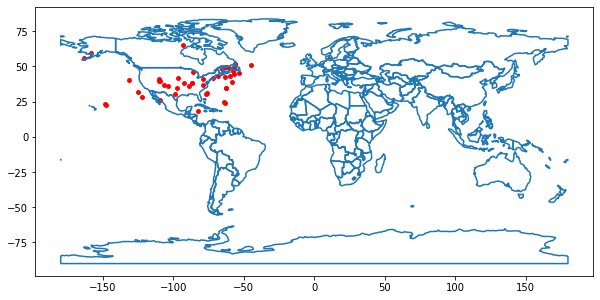

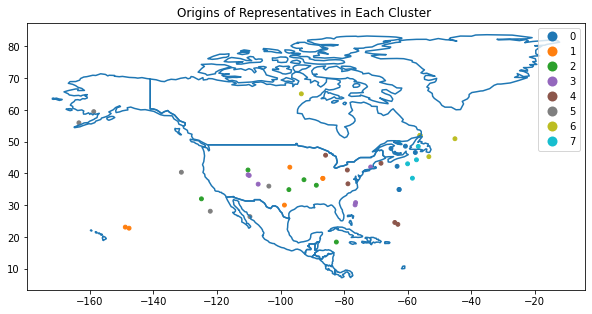

In [6]:
# plotting these latitude longitude values on a map with shapely and geopandas and making a graph for our origin representatives
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt


df = pd.DataFrame(origin_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);
gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);
plt.title('Origins of Representatives in Each Cluster ')

     latitude   longitude  cluster_id                     geometry
0   46.640268  -57.910356           0   POINT (-57.91036 46.64027)
1   47.977748  -55.379571           0   POINT (-55.37957 47.97775)
2   40.403031  -76.205188           0   POINT (-76.20519 40.40303)
3   47.669946  -68.898999           0   POINT (-68.89900 47.66995)
4   47.977748  -55.379571           0   POINT (-55.37957 47.97775)
5   50.557248  -96.653428           0   POINT (-96.65343 50.55725)
6   30.442515  -92.246587           1   POINT (-92.24659 30.44251)
7   34.942068  -86.446469           1   POINT (-86.44647 34.94207)
8   23.118823 -148.834557           1  POINT (-148.83456 23.11882)
9   34.942068  -86.446469           1   POINT (-86.44647 34.94207)
10  38.694580 -112.078850           1  POINT (-112.07885 38.69458)
11  23.644657 -149.967798           1  POINT (-149.96780 23.64466)
12  37.562655  -86.435311           2   POINT (-86.43531 37.56265)
13  42.278679 -110.655435           2  POINT (-110.65543 42.27

Text(0.5, 1.0, 'Destinations of Representatives In Each Cluster')

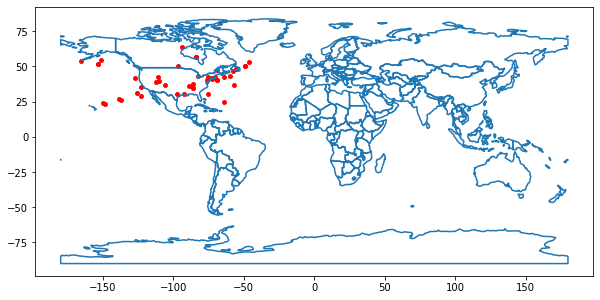

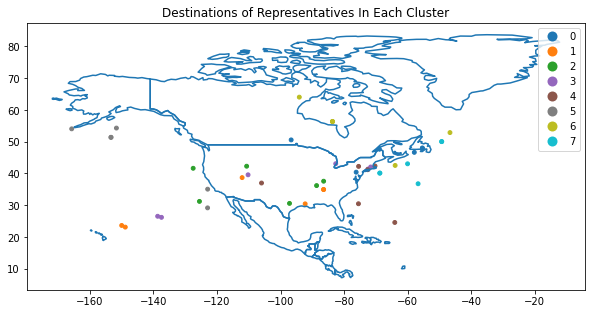

In [7]:
# plotting these latitude longitude values on a map with shapely and geopandas for our destination locations for each representative


df = pd.DataFrame(destination_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);

plt.title('Destinations of Representatives In Each Cluster')

## For each cluster, what is the delay distribution of elements within the cluster?

In [8]:
# grabbing mappings for each cluster for this configuration
if season !=4:
    mapping= spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)).coalesce(1)
else:
    # then we want all data
    mapping = spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)).coalesce(1)
print(mapping.printSchema())

# getting dep delay mean for each cluster in our clustering
# also getting the number of elements in each cluster
# also getting percentages (number of records with delay/all records)
means = []
counts = []
percentages = []
for i in range(len(clusters)):
    if season !=4:
        interested_elements = mapping.where(mapping.tag==i).join(joined.where(joined.Season==season).coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    else:
        interested_elements = mapping.where(mapping.tag==i).join(joined.coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    print('cluster: '+ str(i)+ ' mean depdelay: ' + str(mean))
    means.append(mean['avg(DepDelay)'])
    count = mapping.where(mapping.tag==i).count()
    counts.append(count)
    percentages.append(num_delay/count)
    print('cluster: ' + str(i) + ' number of examples tagged: ' + str(count))
    print('cluster: ' + str(i) + ' number of records with delay: ' + str(num_delay))
    
    
    
    
# getting the mean dep delay for the population and the total count
if season!=4:
    pop_mean = joined.where(joined.Season==season).select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.where(joined.Season==season).count()
else:
    pop_mean  = joined.select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.count()
print('population_mean: ' + str(pop_mean))
print('population count: ' + str(pop_count))




root
 |-- record_id: long (nullable = true)
 |-- tag: integer (nullable = true)

None
cluster: 0 mean depdelay: Row(avg(DepDelay)=78.56083564942583)
cluster: 0 number of examples tagged: 1023635
cluster: 0 number of records with delay: 913143
cluster: 1 mean depdelay: Row(avg(DepDelay)=4.425337375364235)
cluster: 1 number of examples tagged: 29494744
cluster: 1 number of records with delay: 11180485
cluster: 2 mean depdelay: Row(avg(DepDelay)=2.954568935480869)
cluster: 2 number of examples tagged: 19909769
cluster: 2 number of records with delay: 6935148
cluster: 3 mean depdelay: Row(avg(DepDelay)=17.14954375927702)
cluster: 3 number of examples tagged: 12883988
cluster: 3 number of records with delay: 6295421
cluster: 4 mean depdelay: Row(avg(DepDelay)=8.440411059463095)
cluster: 4 number of examples tagged: 26488917
cluster: 4 number of records with delay: 12002482
cluster: 5 mean depdelay: Row(avg(DepDelay)=10.530065928023975)
cluster: 5 number of examples tagged: 5980158
cluster: 

## Plotting percentage of records with a delay per cluster

[]

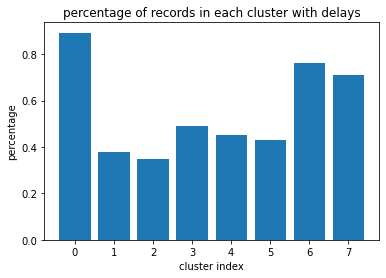

In [9]:
plt.bar([i for i in range(len(percentages))],percentages)
plt.xlabel('cluster index')
plt.ylabel('percentage')
plt.title('percentage of records in each cluster with delays')
plt.plot()

# Plotting number of examples per cluster

[]

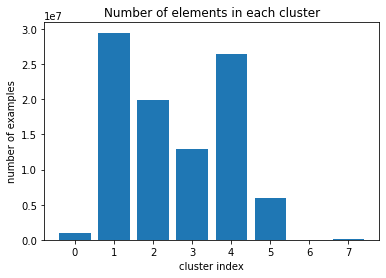

In [10]:
plt.bar([i for i in range(len(counts))],counts)
plt.xlabel('cluster index')
plt.ylabel('number of examples')
plt.title('Number of elements in each cluster')
plt.plot()

## Bar Plot for this Configuration

[]

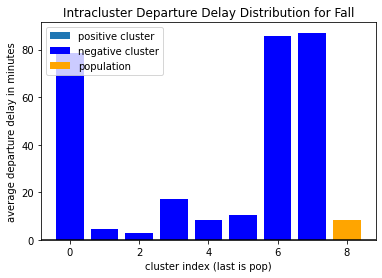

In [11]:

fig = plt.figure()
ax = plt.subplot(111)
positives = []
negatives  = []
for i in range(len(means)):
    if means[i]<0:
        negatives.append((i,means[i]))
    else:
        positives.append((i,means[i]))
#print(zip(*negatives))
first = ax.bar([index for index,value in negatives], [value for index,value in negatives],color='green')
second = ax.bar([index for index,value in positives], [value for index,value in positives],color='blue')
third = ax.bar([len(means)],[pop_mean],color='orange')
ax.axhline(0, color='k')
ax.legend((first,second,third),('positive cluster','negative cluster','population'))
plt.xlabel('cluster index (last is pop)')
plt.ylabel('average departure delay in minutes')
plt.title('Intracluster Departure Delay Distribution for Fall')
plt.plot()

## Cluster analysis for Cluster 7

In [12]:
# intracluster analysis
cluster_index = 7

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(20)
    pop = joined.where(joined.Season==season).drop('Season','record_id')
    pop_stats = pop.select(*[[F.mean(c).alias(c+'_mean') for c in pop.columns] + \
                                     [F.stddev_pop(c).alias(c+'_stddev') for c in pop.columns]]).collect()[0]
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.coalesce(20),'record_id').drop('Season','record_id','tag').coalesce(20)
    pop_stats = stats

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=95.70215268530848, DepDelay_mean=87.12960497114958, ActualElapsedTime_mean=130.3997114957834, Distance_mean=684.2811806480248, origin_lat_mean=36.78634615302856, origin_long_mean=-85.63493472088149, dest_lat_mean=34.460387329163424, dest_long_mean=-85.6090642485001, origin_prcp_mean=291.4272525521527, origin_tmax_mean=232.7729249889037, origin_tmin_mean=138.911540168664, origin_awnd_mean=77.78013759431869, dest_prcp_mean=1054.3728362183756, dest_tmax_mean=236.65805592543276, dest_tmin_mean=157.71970705725698, dest_awnd_mean=49.26913004882379, ArrDelay_stddev=111.23907842890131, DepDelay_stddev=107.652795148598, ActualElapsedTime_stddev=64.76397720126589, Distance_stddev=490.10705121188306, origin_lat_stddev=5.295828022017019, origin_long_stddev=12.998656622391485, dest_lat_stddev=6.1214992537706205, dest_long_stddev=11.835347325104713, origin_prcp_stddev=398.5371512830585, origin_tmax_stddev=85.39642194373238, origin_tmin_stddev=80.89933926573941, or

## Plotting stats compared to average for delay attributes

In [13]:


# defining a function to make plots for us
def plot_features(labels,title,interested_stats,pop_stats):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    interested_vals = [interested_stats[label+'_mean'] for label in labels]
    interested_stddevs = [interested_stats[label+'_stddev'] for label in labels]
    pop_vals = [pop_stats[label+'_mean'] for label in labels]
    pop_stddevs = [pop_stats[label+'_stddev'] for label in labels]
    indices = np.arange(len(pop_vals))
    width = 0.35
    first = ax.bar(indices,interested_vals,width,label='cluster',yerr=interested_stddevs)
    second = ax.bar(indices+width,pop_vals,width,label='population',yerr=pop_stddevs)
    ax.set_xticks(indices+width/2)
    ax.set_xticklabels(labels)
    plt.ylabel('value')
    plt.xlabel('feature')
    ax.legend((first,second),('Cluster','Population'))
    plt.title(title)
    plt.plot()

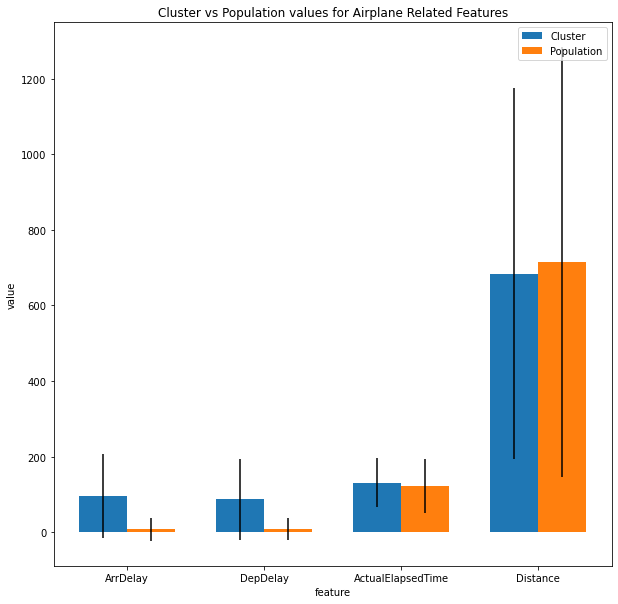

In [14]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

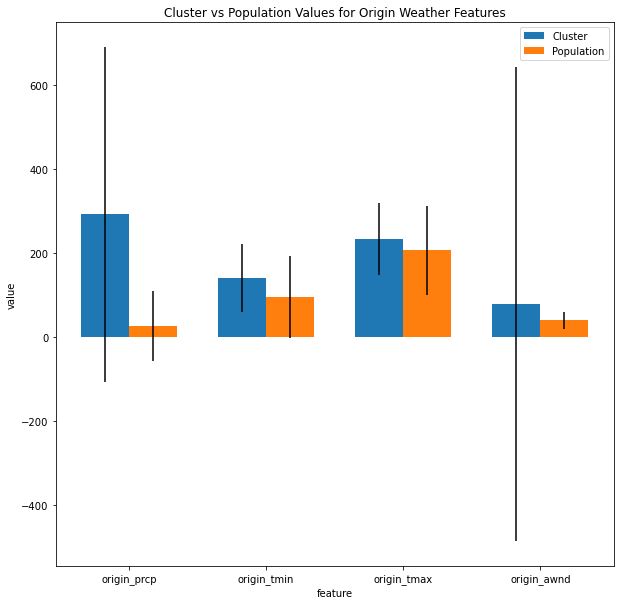

In [15]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

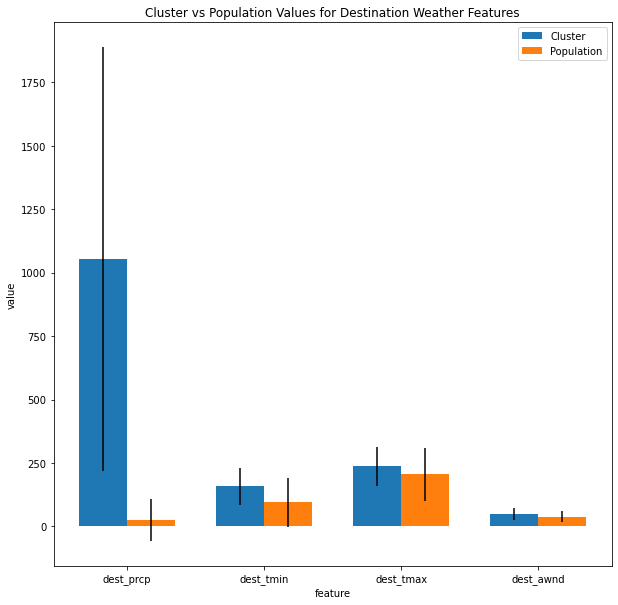

In [16]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## We see much higher precipitation for these flights compared to average. Similarly a large deviation in average windspeeds. These flights are in an eastern US region.

# Analyzing Cluster 6

In [17]:
# intracluster analysis
cluster_index = 6

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(20)
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.coalesce(20),'record_id').drop('Season','record_id','tag').coalesce(20)

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=95.64926553672316, DepDelay_mean=85.56497175141243, ActualElapsedTime_mean=127.04474576271187, Distance_mean=655.3473446327683, origin_lat_mean=37.86933930525659, origin_long_mean=-91.72949289873215, dest_lat_mean=39.23761193945311, dest_long_mean=-91.85358562896498, origin_prcp_mean=1777.3871186440679, origin_tmax_mean=264.79841807909605, origin_tmin_mean=184.78305084745762, origin_awnd_mean=48.835480225988704, dest_prcp_mean=180.8942372881356, dest_tmax_mean=273.050395480226, dest_tmin_mean=174.17084745762713, dest_awnd_mean=43.04225988700565, ArrDelay_stddev=103.78035874404407, DepDelay_stddev=96.58339164361222, ActualElapsedTime_stddev=69.84473359800322, Distance_stddev=502.3256046997971, origin_lat_stddev=8.242264330099413, origin_long_stddev=19.392215145955785, dest_lat_stddev=7.164005093773969, dest_long_stddev=20.701190639257337, origin_prcp_stddev=1502.0654265065773, origin_tmax_stddev=59.06508177005408, origin_tmin_stddev=47.27473191566484,

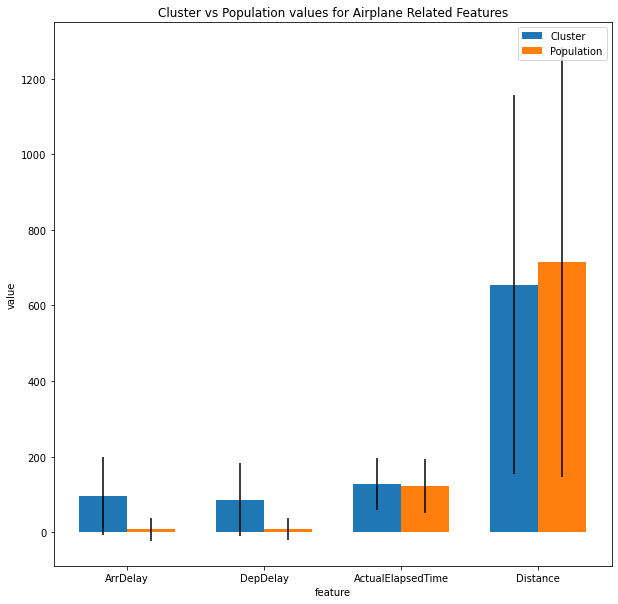

In [18]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

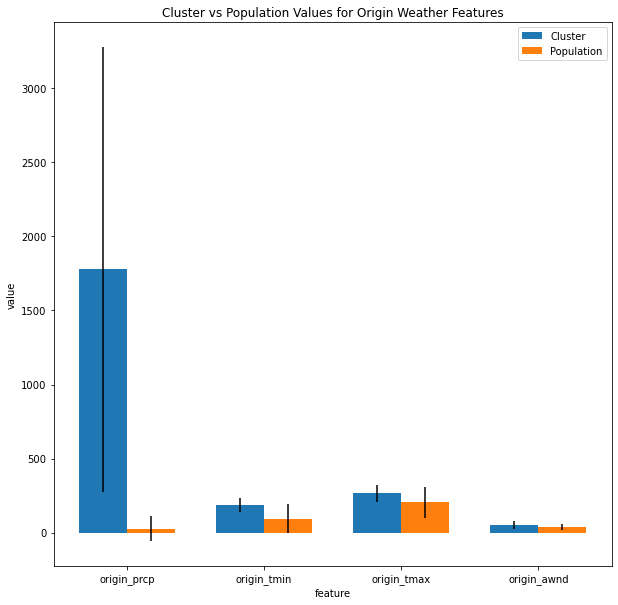

In [19]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

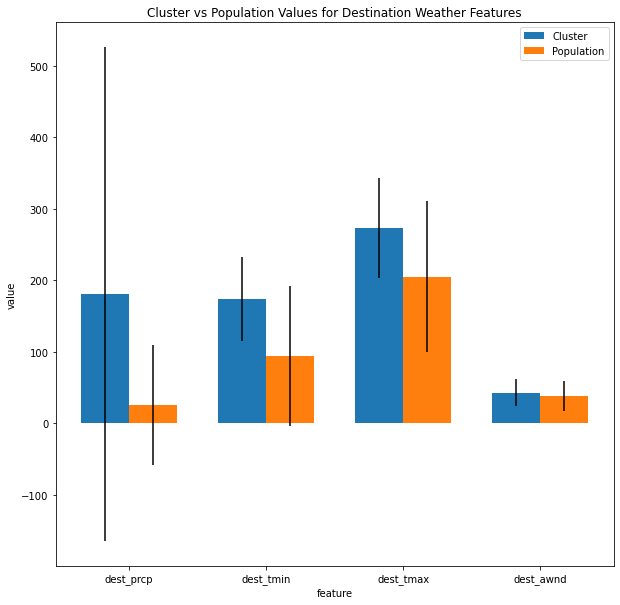

In [20]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## Likewise we see a huge amount of precipitation compared to average for this cluster. We see arrival delays as well and this region also corresponds to the eastern US region.

# Analyzing cluster 2: a cluster with below average delay

In [21]:
# intracluster analysis
cluster_index = 2

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(20)
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.coalesce(20),'record_id').drop('Season','record_id','tag').coalesce(20)

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=0.8759407504928862, DepDelay_mean=2.954568935480869, ActualElapsedTime_mean=95.57292030861835, Distance_mean=496.1473247128081, origin_lat_mean=38.34761446076222, origin_long_mean=-86.27073073481458, dest_lat_mean=38.81479537426505, dest_long_mean=-85.90548439123947, origin_prcp_mean=10.904629481135617, origin_tmax_mean=111.34987668616346, origin_tmin_mean=6.7329727431794915, origin_awnd_mean=42.135217390015924, dest_prcp_mean=12.20356730407068, dest_tmax_mean=100.98248914891981, dest_tmin_mean=-2.0466137000384084, dest_awnd_mean=40.521317700873375, ArrDelay_stddev=16.608623736938227, DepDelay_stddev=12.733825089992274, ActualElapsedTime_stddev=44.68485834802586, Distance_stddev=344.2866559635554, origin_lat_stddev=4.365031486986224, origin_long_stddev=10.859992589982275, dest_lat_stddev=4.055513889819229, dest_long_stddev=11.02197953633998, origin_prcp_stddev=33.09096678416714, origin_tmax_stddev=94.81662260090889, origin_tmin_stddev=85.855134383367

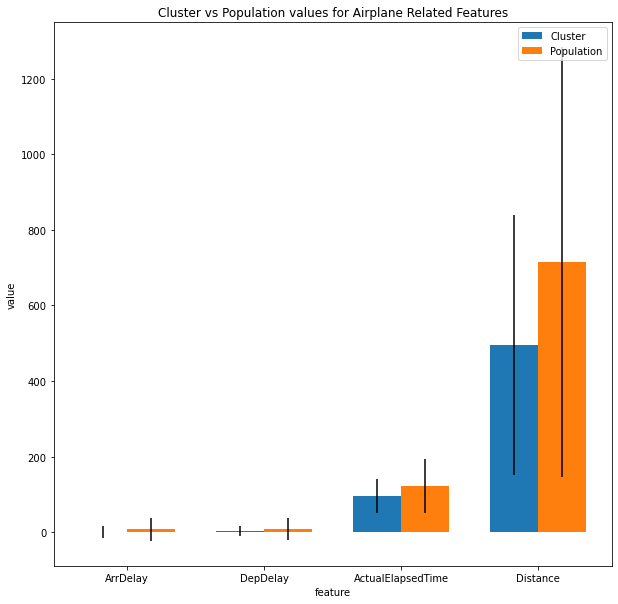

In [22]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

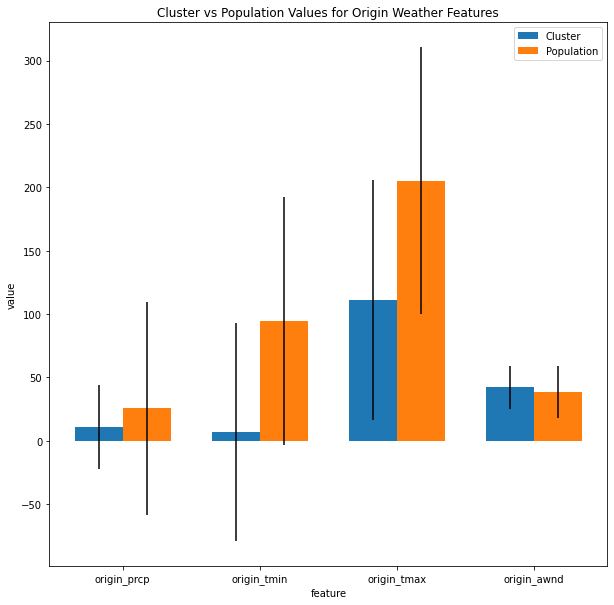

In [23]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

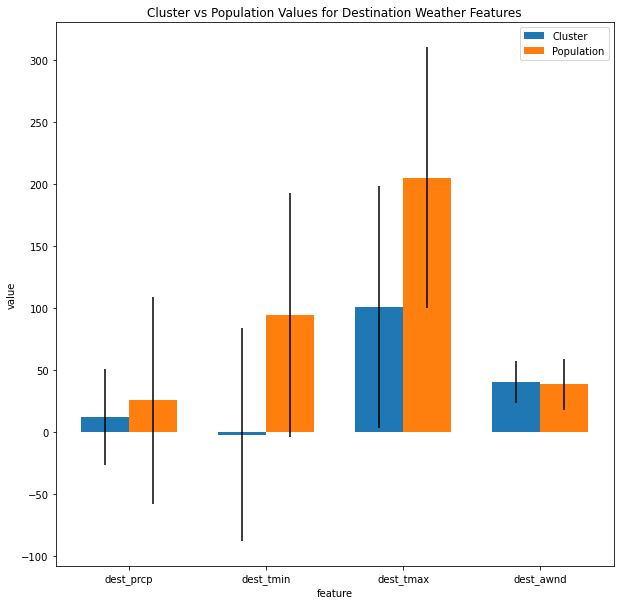

In [24]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## the region for these flights are not in the eastern US region (they seem to be Midwest USA region), and we see that we have a very low level of precipitation with very little departure delay and basically no arrival delay.